In [1]:
from typing import TypedDict
from dotenv import load_dotenv
from langgraph.graph import StateGraph

load_dotenv()

True

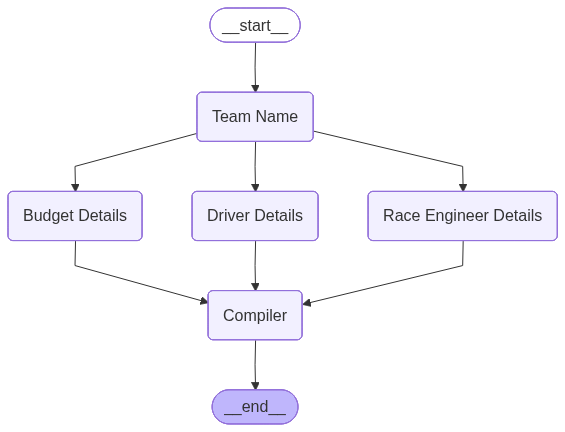

In [2]:
from IPython.core.display import Image
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.constants import START, END
from langchain_community.tools import TavilySearchResults

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

class State(TypedDict):
    Team_Name: str
    Budget: float
    Driver_DB: str
    Race_Engineer_DB: str

    final_answer: str

def search_web_driver(State: State):

    """ Retrieve driver details from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke("F1 and F2 drivers in 2023-2025 and their Salary ")

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"Driver_DB": [formatted_search_docs]}

def search_web_Engineer(State: State):

    """ Retrieve Engineer details from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke("F1 Race Engineers in 2023-2025 ")

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"Race_Engineer_DB": [formatted_search_docs]}

def Fix_Budget(State: State):
    """Use this to get the Budget as Input"""
    return {"Budget": int(input("Enter Budget: "))}

def Team_Name(State: State):
    """Use this to get the Team Name as Input"""
    return {"Team_Name": input("Enter Team Name: ")}

def Compiler(State: State):
    """Use this to Compile the Data and Make suggestions"""


    answer_template = """You are a F1 Team Pricipal for {Team}
                        and you need to make a suggestion of drivers and Race Engineers from {DriverDB} and {RaceEngineerDB} and you have to fit within the given Budget {Budget}. One world class F1 driver, 1 second seat driver and 2 F2 drivers for Future Growth and 2 Race Engineers
                        """
    answer_instructions = answer_template.format(Team=State["Team_Name"], DriverDB=State["Driver_DB"],RaceEngineerDB=State["Race_Engineer_DB"],Budget=State["Budget"])

    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])

    return {"final_answer": answer}

builder = StateGraph(State)

builder.add_node("Team Name",Team_Name)
builder.add_node("Driver Details",search_web_driver)
builder.add_node("Race Engineer Details",search_web_Engineer)
builder.add_node("Budget Details",Fix_Budget)
builder.add_node("Compiler",Compiler)

builder.add_edge(START,"Team Name")
builder.add_edge("Team Name","Driver Details")
builder.add_edge("Team Name","Race Engineer Details")
builder.add_edge("Team Name","Budget Details")

builder.add_edge("Driver Details","Compiler")
builder.add_edge("Race Engineer Details","Compiler")
builder.add_edge("Budget Details","Compiler")
builder.add_edge("Compiler",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [5]:
result = graph.invoke({})

In [6]:
print(result['final_answer'].content)

To fit within the given budget of $32,000,000, we need to strategically select drivers and race engineers. Here's a suggestion:

1. **World Class F1 Driver:**
   - **George Russell (Mercedes)**: $15 million
     - Russell is a strong performer and offers good value for his salary compared to the top earners like Verstappen and Hamilton.

2. **Second Seat Driver:**
   - **Carlos Sainz (Williams)**: $10 million
     - Sainz is experienced and has shown consistent performance, making him a solid choice for the second seat.

3. **F2 Drivers for Future Growth:**
   - **Oliver Bearman (Haas)**: $1 million
   - **Liam Lawson (Red Bull)**: $1 million
     - Both Bearman and Lawson are promising young talents with experience as test and reserve drivers, making them ideal for future growth.

4. **Race Engineers:**
   - **Marcus Dudley (Mercedes-AMG F1 Team)**
     - Dudley has a long history with Mercedes and has contributed to several victories, making him a valuable asset.
   - **Will Joseph (